# TP1 - EJERCICIO 1

**INTEGRANTES:**
* AGUSTIN ARENAS
* SOL KIDONAKIS


**AÑO:** 2024

**RESUMEN**

* EDA:
  Explorar, limpiar y rellenar el dataset
  
  
* RN:
  Modelo - Arq-RN
  
  Métricas de validación - Train-Validation: En el Fit del modelo usar validation_split y Early stopping para detener el entrenamiento cuando la validación deje de mejorar. MSE y MAE
  
  Resumen de los modelos

## BIBLIOTECAS

### DRIVE

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### DATA Y OTROS

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
import math

import warnings
warnings.filterwarnings("ignore")

MODELOS

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score

from keras.callbacks import EarlyStopping
#from scikeras.wrappers import KerasRegressor

In [5]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

## PROBLEMA 1

### ANALISIS EXPLORATORIO Y PREPROCESAMIENTO DEL SET DE DATOS

CARGA DE DATOS

In [6]:
# Alternativas de carga del dataset
# SK
#datos = pd.read_csv('/content/drive/MyDrive/Student_Performance.csv', delimiter = ",")

# AA
datos = pd.read_csv('/content/drive/MyDrive/TUIA/AAII/Student_Performance.csv', delimiter = ",")

datos

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0
...,...,...,...,...,...,...
9995,1,49,Yes,4,2,23.0
9996,7,64,Yes,8,5,58.0
9997,6,83,Yes,8,5,74.0
9998,9,97,Yes,7,0,95.0


In [7]:
# Columnas y Tipos
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


In [8]:
# Estadísticas descriptivas
datos.describe()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,6.530600,4.583300,55.224800
std,2.589309,17.343152,1.695863,2.867348,19.212558
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


In [9]:
# Comprobar valores faltantes
print(datos.isnull().sum())

Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64


In [10]:
# Comprobar filas duplicadas (no seran eliminadas, ya que en este caso es normal)
datos.duplicated().count()

10000

In [11]:
# Mapeo de la columna binaria
datos['Extracurricular Activities'] = datos['Extracurricular Activities'].map({'Yes': 1, 'No': 0})

datos['Extracurricular Activities'].unique()

array([1, 0])

BOXPLOTS DEL DATASET

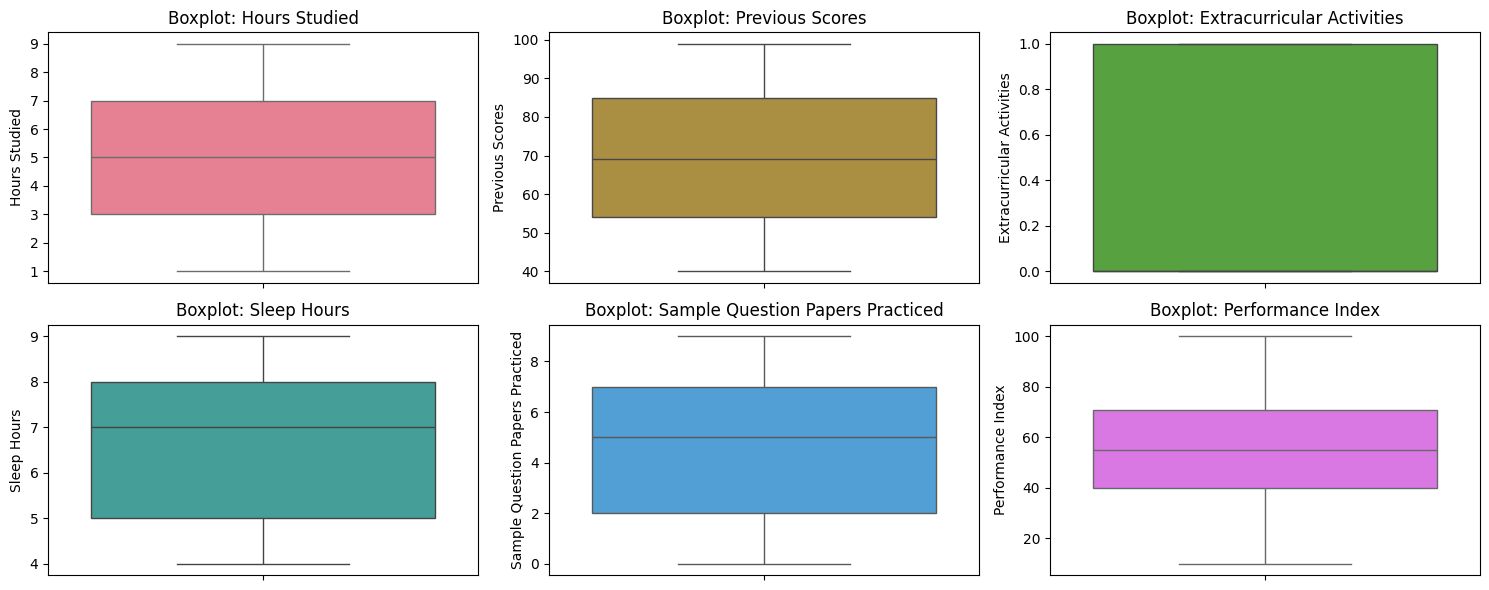

In [12]:
def boxplot_columns(datos, cols_per_row=3):
    """
    Crea un gráfico de boxplots para cada columna en un DataFrame con ejes y independientes.

    Args:
        datos (pd.DataFrame): El DataFrame con los datos a graficar.
        cols_per_row (int): Número de gráficos por fila en la cuadrícula.

    """
    num_cols = datos.shape[1]  # Número de columnas
    num_rows = math.ceil(num_cols / cols_per_row)  # Número de filas necesarias

    # Crear la figura y ejes en una cuadrícula
    fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(cols_per_row*5, num_rows*3))

    # Aplanar el arreglo de ejes para un fácil acceso si es necesario
    axes = axes.flatten()

    # Crear una paleta de colores para los gráficos
    palette = sns.color_palette("husl", num_cols)  # Paleta de colores (husl es uno de los esquemas de Seaborn)

    # Generar los boxplots en cada gráfico
    for i, col in enumerate(datos.columns):
        sns.boxplot(y=datos[col], ax=axes[i], color=palette[i])  # Crear boxplot para cada columna
        axes[i].set_title(f'Boxplot: {col}')  # Establecer título del gráfico
        axes[i].set_ylabel(col)  # Etiqueta en el eje Y independiente

    # Eliminar gráficos vacíos si hay menos gráficos que ejes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Ajustar el espaciado entre los gráficos
    plt.tight_layout()
    plt.show()

# BP del DataFrame 'datos'
boxplot_columns(datos)

No se determino valores atípicos en el dataset, por lo que no es necesario plantear criterios de tratamiento de dichos valores.

HISTOGRAMAS DE LOS DATOS DEL DATASET

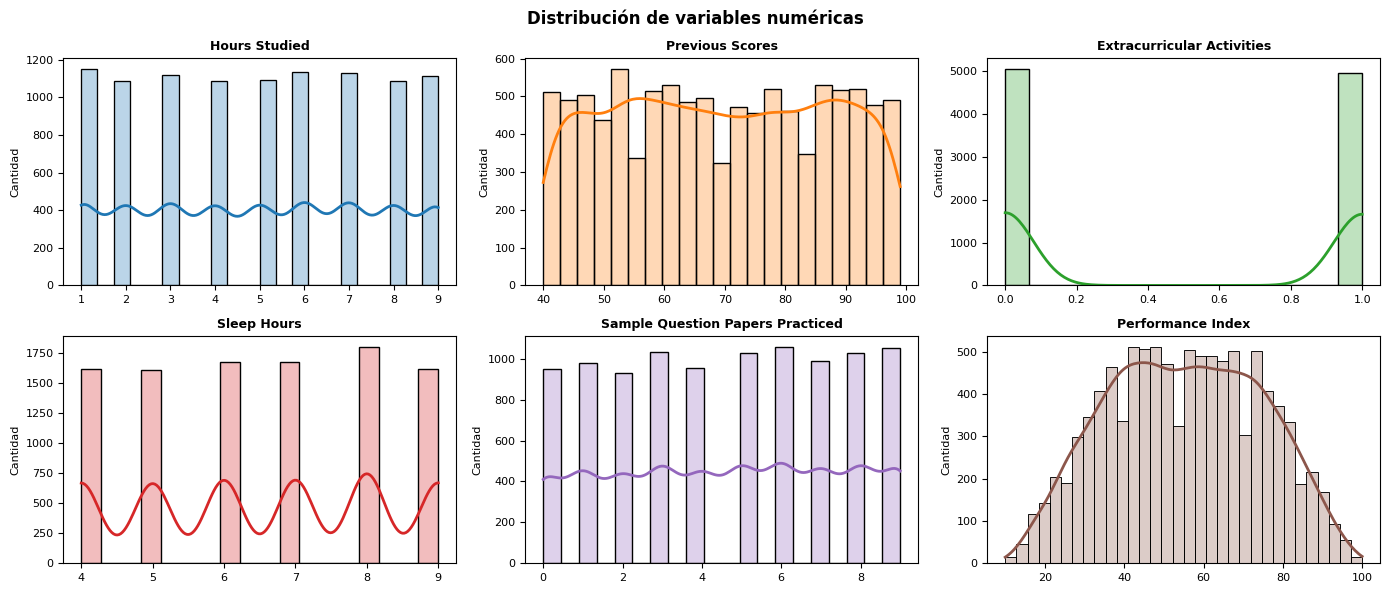

In [13]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================

# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 6))
axes = axes.flat

# Seleccionar las columnas numéricas, incluyendo 'Extracurricular Activities'
columnas_numeric = ['Hours Studied', 'Previous Scores', 'Extracurricular Activities',
                    'Sleep Hours', 'Sample Question Papers Practiced', 'Performance Index']

# Crear los histogramas con KDE
for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data     = datos,
        x        = colum,
        stat     = "count",
        kde      = True,
        color    = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws = {'linewidth': 2},
        alpha    = 0.3,
        ax       = axes[i]
    )
    axes[i].set_title(colum, fontsize = 9, fontweight = "bold")
    axes[i].tick_params(labelsize = 8)
    axes[i].set_xlabel("")

    # Añadir el nombre al eje Y
    axes[i].set_ylabel("Cantidad", fontsize=8)

# Ajustar el diseño del gráfico
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución de variables numéricas', fontsize = 12, fontweight = "bold")
plt.show()


Se observa una distribución uniforme entre los datos, hay una uniformidad entre los diferentes valores posibles de las columnas.
En la columna de Índice de rendimiento, no es uniforme la distribución, mas bien parece una distribución normal.

MATRIZ DE CORRELACION

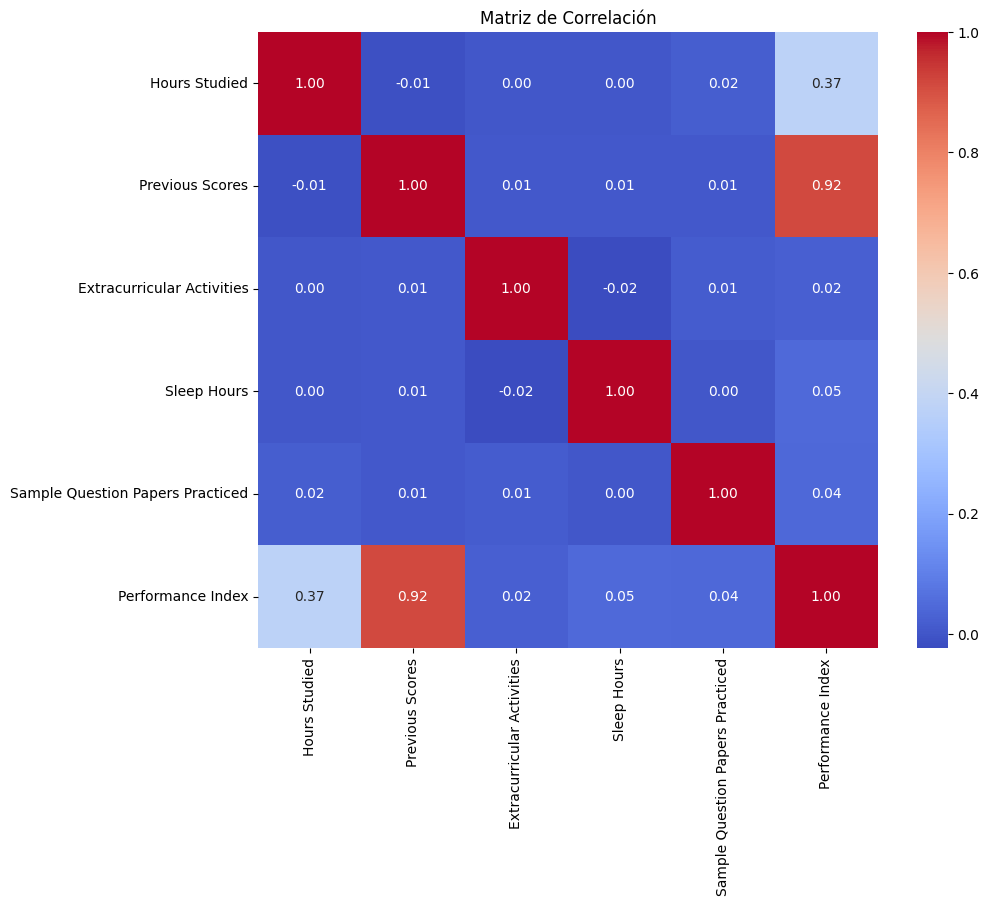

In [14]:
# Matriz de correlación
correlation_matrix = datos.corr()

# Graficar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()

La variable Previous Scores es la mas fuertemente correlacionada con la variable Performance Index, seguida por la variable hours studied.
Aún asi esto no quita a las otras variables de ser importantes, ya que pueden tener otro tipo de correlación no lineal, la cual las RN pueden contemplar y aprovechar los datos.

GRAFICOS DE DISPERSION RESPECTO AL INDICE DE RENDIMIENTO

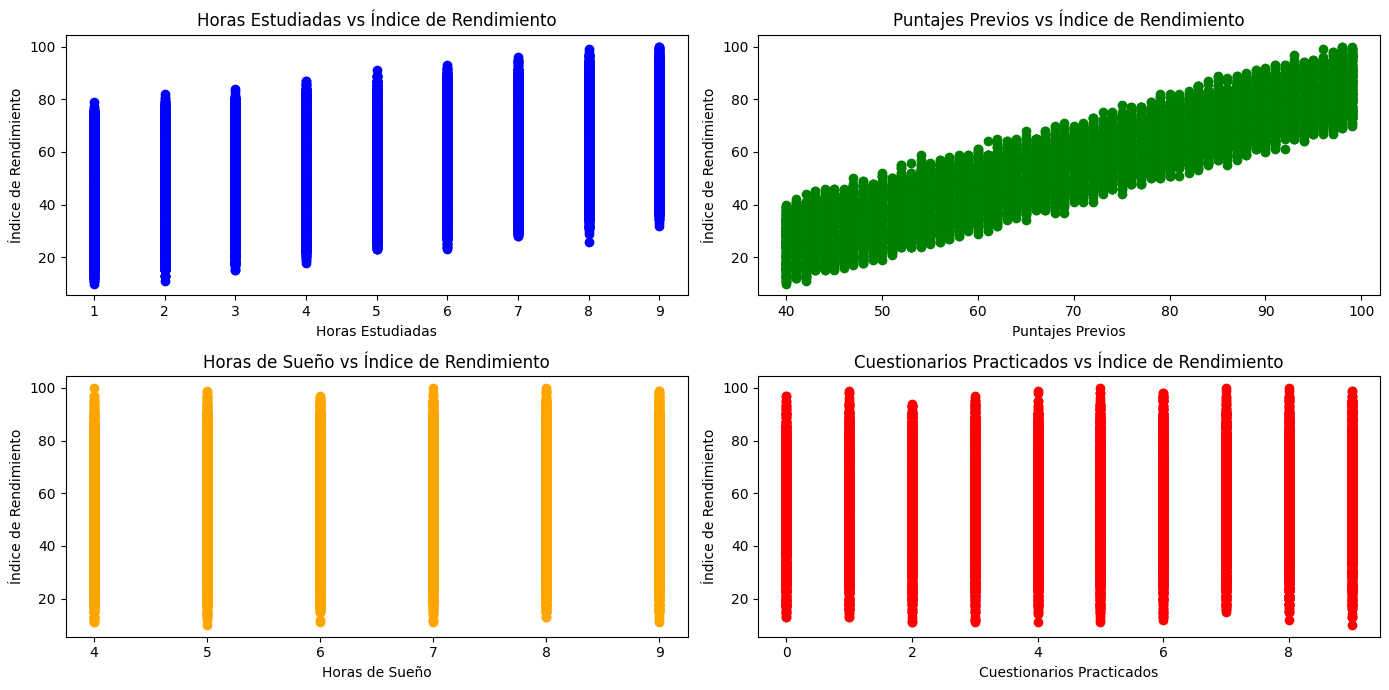

In [15]:
# Gráficos de dispersión
plt.figure(figsize=(14, 7))

# Horas estudiadas vs Rendimiento
plt.subplot(2, 2, 1)
plt.scatter(datos['Hours Studied'], datos['Performance Index'], color='blue')
plt.title('Horas Estudiadas vs Índice de Rendimiento')
plt.xlabel('Horas Estudiadas')
plt.ylabel('Índice de Rendimiento')

# Puntajes previos vs Rendimiento
plt.subplot(2, 2, 2)
plt.scatter(datos['Previous Scores'], datos['Performance Index'], color='green')
plt.title('Puntajes Previos vs Índice de Rendimiento')
plt.xlabel('Puntajes Previos')
plt.ylabel('Índice de Rendimiento')

# Horas de sueño vs Rendimiento
plt.subplot(2, 2, 3)
plt.scatter(datos['Sleep Hours'], datos['Performance Index'], color='orange')
plt.title('Horas de Sueño vs Índice de Rendimiento')
plt.xlabel('Horas de Sueño')
plt.ylabel('Índice de Rendimiento')

# Cuestionarios practicados vs Rendimiento
plt.subplot(2, 2, 4)
plt.scatter(datos['Sample Question Papers Practiced'], datos['Performance Index'], color='red')
plt.title('Cuestionarios Practicados vs Índice de Rendimiento')
plt.xlabel('Cuestionarios Practicados')
plt.ylabel('Índice de Rendimiento')

plt.tight_layout()
plt.show()

Se observa datos distribuidos con la variable puntajes previos, a diferencia de las otras variables que se encuentran mas fuertemente agrupadas por valores unicos.

### DEFINICION Y ENTRENAMIENTO DEL MODELO

SE PROBARA DIFERENTES ARQUITECTURAS HASTA OBTENER UN MODELO OPTIMO Y BUENAS METRICAS.

#### DATASET: VARIABLES Y TARGET

In [92]:
# Función para aislar la target

def split_dataset(data, target_column):
    # Asegurarse de que la columna objetivo existe en el dataset
    if target_column not in data.columns:
        raise ValueError(f"La columna '{target_column}' no está en el dataset")

    # Crear la variable Y con la columna objetivo
    Y = data[target_column].to_numpy()

    # Crear las variables X1, X2, ..., ignorando la columna objetivo
    X_columns = [col for col in data.columns if col != target_column]

    # Convertir las columnas en arrays numpy y asignarlas a variables dinámicas
    X_vars = {f"X{i+1}": data[col].to_numpy() for i, col in enumerate(X_columns)}

    return X_vars, Y

In [93]:
X_vars, Y = split_dataset(datos, 'Performance Index')

n = len(X_vars)
print("Cantidad de variables: ", n)

Cantidad de variables:  5


In [94]:
X_vars

{'X1': array([7, 4, 8, ..., 6, 9, 7]),
 'X2': array([99, 82, 51, ..., 83, 97, 74]),
 'X3': array([1, 0, 1, ..., 1, 1, 0]),
 'X4': array([9, 4, 7, ..., 8, 7, 8]),
 'X5': array([1, 2, 2, ..., 5, 0, 1])}

In [95]:
# Convertir el diccionario X_vars en un DataFrame
X_train = pd.DataFrame(X_vars)

# Por nomenclatura
y_train = Y

ESTANDARIZAR

In [96]:
# Crear un objeto StandardScaler
scaler = StandardScaler()

# Ajustar el scaler solo con los datos de entrenamiento y escalar
x_train = scaler.fit_transform(X_train)

# Usar el scaler ajustado para escalar el conjunto de prueba
x_test = scaler.transform(X_test)

In [97]:
print(x_train.shape)
print(y_train.shape)

(10000, 5)
(10000,)


#### **MODELO SIN REGULARIZACION**

In [98]:
# RN ARQ: n_vars - 20 - 10 - 1
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(n,)),
    tf.keras.layers.Dense(units=20, activation='linear'),
    tf.keras.layers.Dense(units=10, activation='linear'),
    tf.keras.layers.Dense(units=1, activation='linear')])

In [99]:
# Compilar
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

SE APLICARA EARLY STOPPING PARA CONTROLAR LA METRICA DE VALIDACION (val_loss-mse), EN CASO DE NO MEJORAR DESPUES DE 9 EPOCAS SE CORTARA EL ENTRENAMIENTO.

El argumento patience es útil para evitar un sobreentrenamiento (overfitting), ya que puede detener el entrenamiento antes de que el modelo empiece a ajustarse demasiado a los datos de entrenamiento.

In [100]:
# Early stopping para detener el entrenamiento cuando la validación deje de mejorar
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=9, restore_best_weights=True)

# Entrenar el modelo con un conjunto de validación
history = model.fit(x=x_train, y=y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 479.0868 - mae: 11.6744 - val_loss: 6.0326 - val_mae: 1.9503
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3498 - mae: 1.8436 - val_loss: 5.9144 - val_mae: 1.9359
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.1223 - mae: 1.9811 - val_loss: 5.8609 - val_mae: 1.9141
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.7606 - mae: 1.9181 - val_loss: 7.4398 - val_mae: 2.1929
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.6640 - mae: 2.0436 - val_loss: 4.7514 - val_mae: 1.7314
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.7751 - mae: 1.9005 - val_loss: 5.5564 - val_mae: 1.8837
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.0936 - mae: 1.9620 - val_loss: 4.8386 - val_mae: 1.7398
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.8612 - mae: 2.0694 - val_loss: 8.0844 - val_mae: 2.2609
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step -

In [101]:
# Guardar val_mae
model_mae = round(history.history['val_mae'][-1],3)
print(f"Precisión del modelo en validación: {model_mae}")

Precisión del modelo en validación: 1.831


PLOTEAMOS EL COMPORTAMIENTO DE LAS METRICAS DURANTE EL ENTRENAMIENTO

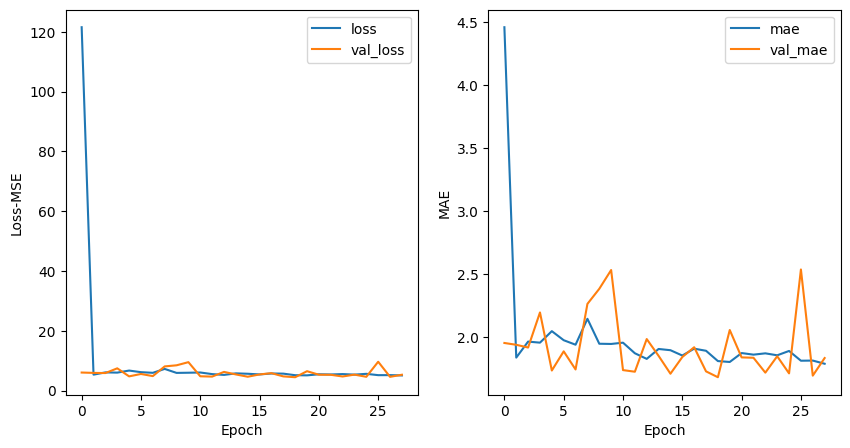

In [102]:
# Plot: Train history loss-mse y mae
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss-MSE')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['val_mae'], label = 'val_mae')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(loc='upper right')

plt.show()

#### **MODELO CON DROPOUT Y REGULARIZACION L1 Y L2**

In [103]:
# RN ARQ: n - Dropout - 20-l1-l2 - 10-l1-l2 - Dropout - 1
model_r = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(n,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=20, activation='linear', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.1, l2=0.1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=10, activation='linear', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.1, l2=0.1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation='linear')])

In [104]:
# Compilar
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
model_r.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

SE APLICARA EARLY STOPPING PARA CONTROLAR LA METRICA DE VALIDACION (val_loss-mse), EN CASO DE NO MEJORAR DESPUES DE 9 EPOCAS SE CORTARA EL ENTRENAMIENTO.

El argumento patience es útil para evitar un sobreentrenamiento (overfitting), ya que puede detener el entrenamiento antes de que el modelo empiece a ajustarse demasiado a los datos de entrenamiento.

In [105]:
# Early stopping para detener el entrenamiento cuando la validación deje de mejorar
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=9, restore_best_weights=True)

# Entrenar el modelo con un conjunto de validación
history_r = model_r.fit(x=x_train, y=y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 808.1691 - mae: 20.2812 - val_loss: 79.6206 - val_mae: 6.9529
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 196.3047 - mae: 10.4342 - val_loss: 43.4671 - val_mae: 4.9487
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 175.9062 - mae: 9.8140 - val_loss: 65.7505 - val_mae: 6.3641
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 159.2953 - mae: 9.2538 - val_loss: 21.6955 - val_mae: 3.2068
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 152.9043 - mae: 9.1155 - val_loss: 76.6391 - val_mae: 6.9965
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 156.7312 - mae: 9.0224 - val_loss: 66.6427 - val_mae: 6.3753
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 141.2830 - mae: 8.6320 - val_loss: 34.2241 - val_mae: 4.2697
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 134.3399 - mae: 8.3387 - val_loss: 21.0725 - val_mae: 3.0540
Epoch 9/50
250/250 ━━━━━━━━━━━

In [106]:
# Guardar val_mae
model_r_mae = round(history_r.history['val_mae'][-1],3)
print(f"Precisión del modelo en validación: {model_r_mae}")

Precisión del modelo en validación: 4.574


PLOTEAMOS EL COMPORTAMIENTO DE LAS METRICAS DURANTE EL ENTRENAMIENTO

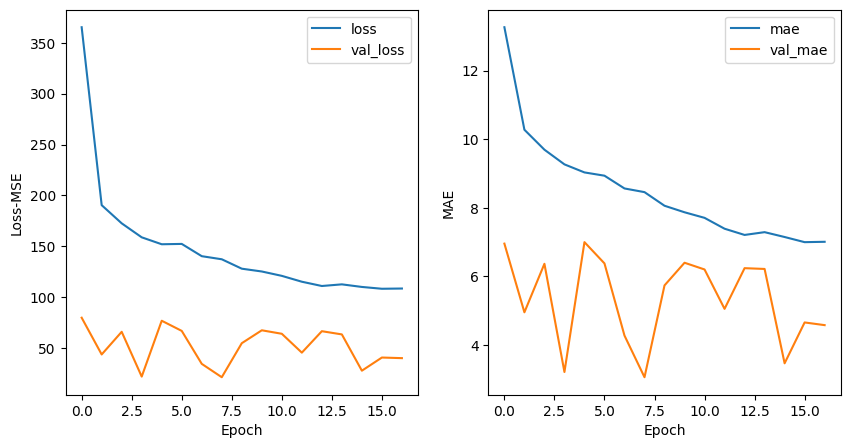

In [107]:
# Plot: Train history loss-mse y mae
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history_r.history['loss'], label='loss')
plt.plot(history_r.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss-MSE')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_r.history['mae'], label='mae')
plt.plot(history_r.history['val_mae'], label = 'val_mae')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(loc='upper right')

plt.show()

#### MODELO CON 2 VARIABLES FUERTEMENTE CORRELACIONADAS

In [108]:
# Variables mas correlacionadas con la target
x_train_m = x_train[:, 0:2]
x_train_m

array([[ 0.77518771,  1.70417565],
       [-0.38348058,  0.72391268],
       [ 1.16141048, -1.06362569],
       ...,
       [ 0.38896495,  0.7815752 ],
       [ 1.54763324,  1.5888506 ],
       [ 0.77518771,  0.26261245]])

In [109]:
# RN ARQ: 2_vars - 10 - 5 - 1
model2vars = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(units=10, activation='linear'),
    tf.keras.layers.Dense(units=5, activation='linear'),
    tf.keras.layers.Dense(units=1, activation='linear')])

In [110]:
# Compilar
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
model2vars.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

SE APLICARA EARLY STOPPING PARA CONTROLAR LA METRICA DE VALIDACION (val_loss-mse), EN CASO DE NO MEJORAR DESPUES DE 9 EPOCAS SE CORTARA EL ENTRENAMIENTO.

El argumento patience es útil para evitar un sobreentrenamiento (overfitting), ya que puede detener el entrenamiento antes de que el modelo empiece a ajustarse demasiado a los datos de entrenamiento.

In [111]:
# Early stopping para detener el entrenamiento cuando la validación deje de mejorar
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=9, restore_best_weights=True)

# Entrenar el modelo con un conjunto de validación
history2vars = model2vars.fit(x=x_train_m, y=y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 644.7542 - mae: 14.7812 - val_loss: 5.4458 - val_mae: 1.8554
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.4181 - mae: 1.8453 - val_loss: 5.7727 - val_mae: 1.8967
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.5332 - mae: 1.8792 - val_loss: 6.1827 - val_mae: 1.9612
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.8490 - mae: 1.9308 - val_loss: 6.3198 - val_mae: 1.9798
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.6251 - mae: 1.8985 - val_loss: 7.0116 - val_mae: 2.1141
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.1696 - mae: 1.9821 - val_loss: 5.5683 - val_mae: 1.8674
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1338 - mae: 1.9621 - val_loss: 5.9504 - val_mae: 1.9320
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.4869 - mae: 2.0403 - val_loss: 8.3023 - val_mae: 2.3188
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step -

In [112]:
# Guardar val_mae
model2vars_mae = round(history2vars.history['val_mae'][-1],3)
print(f"Precisión del modelo en validación: {model2vars_mae}")

Precisión del modelo en validación: 1.928


PLOTEAMOS EL COMPORTAMIENTO DE LAS METRICAS DURANTE EL ENTRENAMIENTO

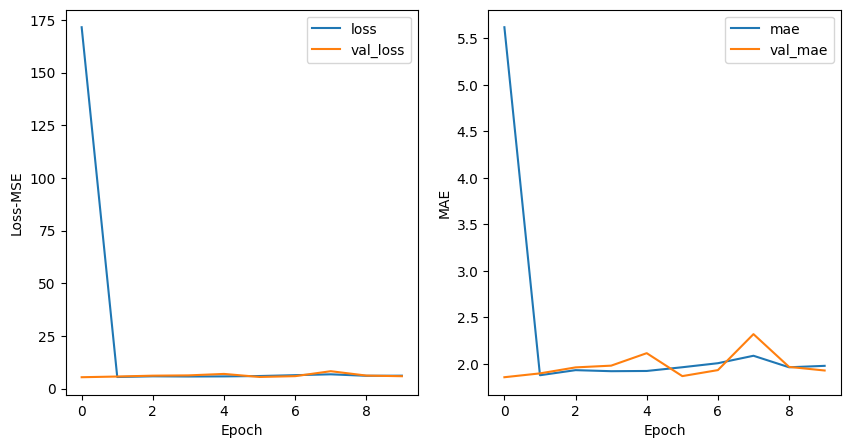

In [113]:
# Plot: Train history loss-mse y mae
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history2vars.history['loss'], label='loss')
plt.plot(history2vars.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss-MSE')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history2vars.history['mae'], label='mae')
plt.plot(history2vars.history['val_mae'], label = 'val_mae')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(loc='upper right')

plt.show()

## RESUMEN DE LOS MODELOS

MAE EN VALIDACIÓN DE LOS MODELOS ENTRENADOS

In [115]:
models_performance = {
    "Modelo | ARQ: 5vars-20-10-1": model_mae,
    "Modelo-Dropout-L1-L2 | ARQ: 5vars-20-10-1": model_r_mae,
    "Modelo 2VARS de Alta correlación | ARQ: 2vars-10-5-1": model2vars_mae}

for model, acc in models_performance.items():
    print(f"{model}: {acc} val_mae")

Modelo | ARQ: 5vars-20-10-1: 1.831 val_mae
Modelo-Dropout-L1-L2 | ARQ: 5vars-20-10-1: 4.574 val_mae
Modelo 2VARS de Alta correlación | ARQ: 2vars-10-5-1: 1.928 val_mae


## CONCLUSIONES

Sabiendo que se tomó de base una arquitectura neuronal del tipo: n_vars - 20 - 10 - 1; excepto para el último que tenía aprox la mitad de las variables y por ende se dividió a la mitad la arquitectura y teniendo los resultados val_mae. Podemos concluir:

El modelo inicial en comparación con el modelo regularizado, resultó ser mejor en mae, indicando que para este caso no hay un sobreajuste a controlar, la explicabilidad es suficiente con el modelo inicial.

Continuando con el modelo inicial, ahora en comparación con el modelo de 2 variables, se puede decir, que con la mitad de arquitectura y cantidad de datos se llega a resultados similares de val_mae, lo que significa una optimización del modelo inicial. Además, se observó en las gráficas de variación de mae vs épocas un comportamiento menos errático frente a los demás modelos.

En conclusión, el modelo final [modelo de 2 variables] sería una opción óptima para la resolución del problema.